#### Looking at the salmon expression estimates vs the real read counts outputted from polyester

In [64]:
import pandas as pd
import sqlite3
import math
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [43]:
# Get real read counts
filename = "/shared/sudlab1/General/projects/utrons_project/Simulations/SimulationUtronsQuant/realCounts.txt"
realCounts = pd.read_csv(filename, sep="\t", header=None, index_col=0)
lengths = realCounts.ix[:,22]
txnames = realCounts.ix[:,21]


# Get RPK values
def getRpks(col, num):
    col = pd.concat([col, lengths], axis=1)
    col["%d"%num] = col[num] / (col[22]/1000)
    return col["%d"%num]


# Get RPK totals
def getTotals(col):
    total = sum(col)
    return total 


# Get sample tpms
def getTpms(col, scalingfactor, num):
    col["tpm"] = (col / scalingfactor)
    return col["tpm"]


# Run the above functions and return a dataframe
def runFunctions(num):
    column = realCounts[num]
    temp1 = getRpks(column, num)
    total = (getTotals(temp1))
    scalingfactor = total / 1000000
    a = getTpms(temp1, scalingfactor, num)
    return a
    

# cycle through functions with all 20 samples and get DF of real tpms
realTpms = txnames
for num in range(1,21,1):
    sampleTpms = runFunctions(num)
    realTpms = pd.concat([realTpms, sampleTpms], axis=1)
    
realTpms[0:5]

,21,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,,
0,ENST00000456328,5.067741,4.101791,5.067741,4.451921,4.899155,4.293158,5.067741,4.899155,4.899155,...,4.731721,4.101791,5.067741,5.067741,4.101791,4.101791,4.899155,4.293158,4.451921,4.101791
1,ENST00000450305,4.690853,3.883469,4.690853,3.796983,5.163601,4.265955,4.690853,5.163601,5.163601,...,4.850001,3.883469,4.690853,4.690853,3.883469,3.883469,5.163601,4.265955,3.796983,3.883469
2,ENST00000488147,3.687019,3.377186,3.687019,2.905569,4.915205,4.027307,3.687019,4.915205,4.915205,...,4.394382,3.377186,3.687019,3.687019,3.377186,3.377186,4.915205,4.027307,2.905569,3.377186
3,ENST00000619216,3.319595,3.007785,3.319595,2.614045,4.536473,3.821522,3.319595,4.536473,4.536473,...,4.033159,3.007785,3.319595,3.319595,3.007785,3.007785,4.536473,3.821522,2.614045,3.007785
4,ENST00000473358,4.586511,3.844869,4.586511,3.661621,5.199104,4.288477,4.586511,5.199104,5.199104,...,4.848854,3.844869,4.586511,4.586511,3.844869,3.844869,5.199104,4.288477,3.661621,3.844869


In [40]:
# Get salmon Estimated Read Counts

# Connect to salmon db and annotations
cnx = sqlite3.connect('/shared/sudlab1/General/projects/utrons_project/Simulations/SimulationUtronsQuant/SimulationUtrons.salmon_extra20samples.db')
cnx.execute("ATTACH '/shared/sudlab1/General/annotations/hg38_noalt_ensembl85/csvdb' as annotations")

In [41]:
# get salmon tpms using sql queries and concatenating the dataframes

def getSalmonTpms(sample, run, index):
    query_text1 = '''
        SELECT name, tpm AS tpm
        FROM salmon_quant AS q
        WHERE Name like "ENS%" and q.track="'''+sample+'''"
        ORDER BY name
        '''
    
    sampletpms = pd.read_sql_query(query_text1, cnx)
    sampletpms["%d"%index] = sampletpms["tpm"]
    if run == 1:
        return sampletpms[["Name", "%d"%index]]
    else:
        return sampletpms["%d"%index]
    
    
salmonTpms = getSalmonTpms("GC-WT-41", 1, 1)
for num in range(42,61,1):
    sample = "GC-WT-%d" % num
    indexnum = num - 40
    tpms = getSalmonTpms(sample, 0, indexnum)
    salmonTpms = pd.concat([salmonTpms, tpms], axis=1)

Populating the interactive namespace from numpy and matplotlib


/home/mba13ns/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


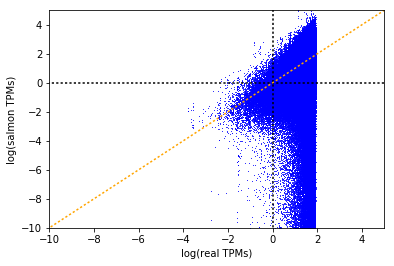

In [68]:
%pylab inline

def plotVals(dataframe):
    realvals = dataframe.ix[:,1].tolist()
    realvals = [np.log(a) for a in realvals]
    
    salmonvals = dataframe.ix[:,3].tolist()
    salmonvals = [np.log(a) for a in salmonvals]
    
    pylab.plot(realvals,salmonvals, ',', color="blue", alpha=0.8)
    
    correlation = spearmanr(salmonvals, realvals)
    return correlation[0]
 
correlations =[]
for sample in range(1,21,1):
    salmon = salmonTpms[["Name", str(sample)]]
    real = realTpms[[21, str(sample)]]
    merged = pd.merge(real, salmon, left_on=21, right_on="Name")
    x = plotVals(merged)
    correlations.append(x)

# Plot dashed lines
pylab.plot([-25,15], [0,0], ":k", color="black")
pylab.plot([0,0], [-25,15], ":k", color="black")
pylab.plot([-25,15], [-25,15], ":k", color="orange")
    
    
# Figure options    
pylab.xlim(-10,5); pylab.ylim(-10,5)
pylab.xlabel("log(real TPMs)"); pylab.ylabel("log(salmon TPMs)")
pylab.savefig("./images/6_SalmonVsReal", dpi=500)


In [90]:
print sum(correlations) / len(correlations)

0.387244203809
